# Notebook for comparing different marginal likelihood estimators for VAEs as well as the performance of MH when using these estimators

## Initialization

In [11]:
%run _init_notebook.ipynb
from approxmh.utilities import *
from approxmh.y_utils import *
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage, create_serpentine
from approxmh.distribution_metrics import *
from approxmh.sequential_mcmc import run_annealed_importance_sampling, DensityMixture
from approxmh.vae import VAE, VAETrainer, get_filename
from approxmh.gan_latent_space_distributions import SNGANLatentSpace
from approxmh.likelihood_estimators import *
from approxmh.kernels import LangevinKernel

def model_file(model, target_name):
    return Path(MODEL_DIR, get_filename(model, target_name))

def save_model(model, target_name):
    model.save_knowledge(model_file(model, target_name))

def load_model(model, target_name):
    model.load_knowledge(model_file(model, target_name))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


## Targets

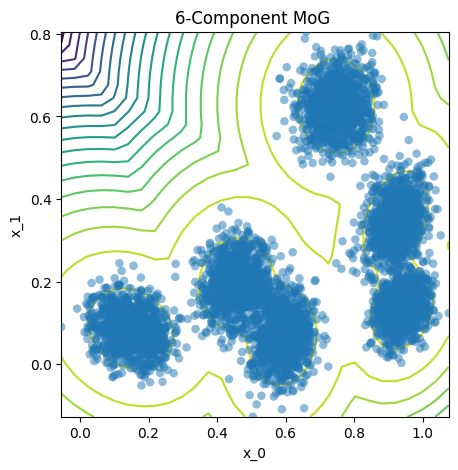

In [12]:
target_type = 0
plot_samples = True

if target_type == 0:
    target = create_random_gaussian_mixture(dim=2, n_components=6, mean_lim=(0, 1), variance_lim=(0.001, 0.004), device=device, seed=43)
elif target_type == 1:
    try:
        plot_samples = False
        target = SNGANLatentSpace(device=device, temperature=1.0)
    except torch.cuda.OutOfMemoryError:
        print("Memory allocation failed")
        del target
elif target_type == 2:
    target = create_serpentine(n_sections=3, section_height=1, device=device)

visualize_distribution(target, sample_size=6_000, levels=20, plot_samples=plot_samples)
torch.cuda.empty_cache()

## VAE Training/Loading

In [13]:
vae = VAE(
    data_dim=target.dim,
    hidden_dims=(4, 4, 4, 4, 4),
    latent_dim=target.dim,
    device=device
)

# True -- train model, False -- load model from file
TRAIN_VAE = False

In [14]:
%%time

if TRAIN_VAE:
    x_train = target.sample((16_384,))
    print('VAE parameters:', count_parameters(vae))
    #optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=250)
    trainer = VAETrainer(
        vae, target, batch_size=2048, no_kl_penalty_epochs=10, kl_annealing_epochs=100, 
        warmup_period=2, optimizer=optimizer, scheduler=scheduler, device=device
    )
    trainer.fit(x_train, n_epochs=500, plot_interval=10)
    save_model(vae, target.name)
else:
    load_model(vae, target.name)

CPU times: user 2.64 ms, sys: 479 µs, total: 3.11 ms
Wall time: 7.21 ms


## Testing SMC Estimates

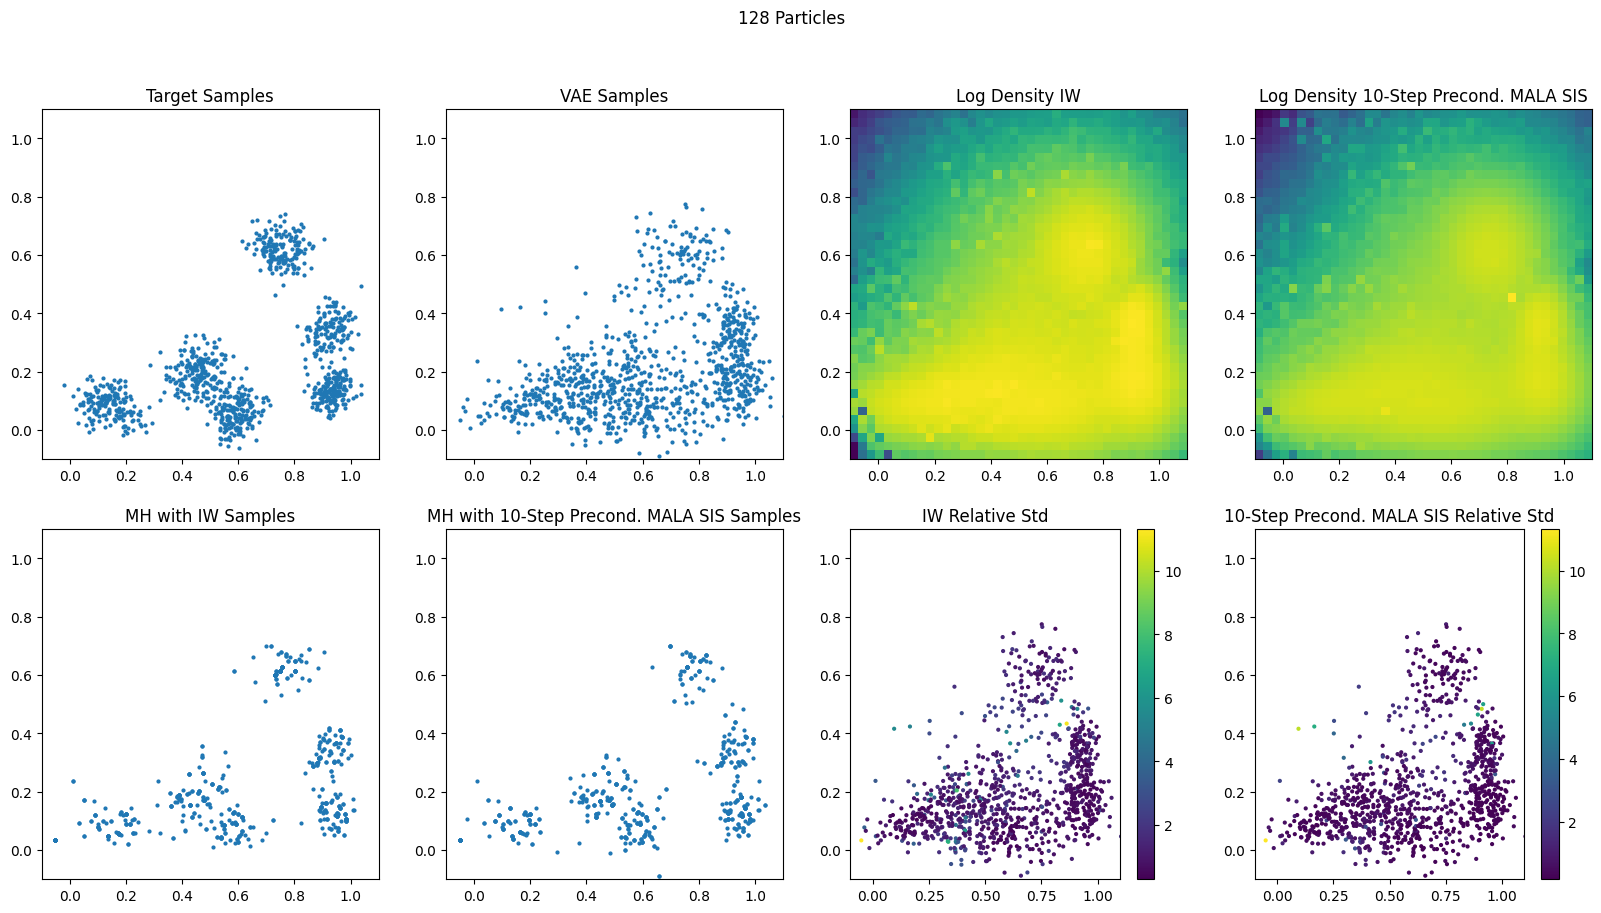

In [9]:
def compare_estimators_for_mh():
    # general parameters
    n_samples = 1000
    # Estimators
    L = 128
    iw_estimator = IWLikelihoodEstimator(
        model=vae,
        L=L
    )
    sis_estimator = SISLikelihoodEstimator(
        model=vae,
        L=L,
        time_step=0.8,
        precondition=True,
    )
    # plotting params
    xlim = (-0.1, 1.1)
    ylim = (-0.1, 1.1)
    d = 40
    x = np.linspace(*xlim, d)
    y = np.linspace(*ylim, d)
    X, Y = np.meshgrid(x, y)
    points = torch.tensor(np.vstack((X.ravel(), Y.ravel())).T, dtype=torch.float).to(device)

    vae_samples = vae.sample((n_samples,))
    cutoff = get_log_prob_quantile(target, q=0)

    marginal_estimators = [iw_estimator, sis_estimator]
    n_est = len(marginal_estimators)

    target_logd = target.log_prob(points).reshape(d, d)
    sc = [0] * n_est
    
    fig, axs = plt.subplots(ncols=2+n_est, nrows=2, figsize=(20,10))
    fig.suptitle(f'{L} Particles')
    axs = axs.flatten()
    axs[0].set_title('Target Samples')
    axs[0].scatter(*pl(target.sample((n_samples,))), s=4)
    axs[1].set_title('VAE Samples')
    axs[1].scatter(*pl(vae_samples), s=4)
    for i, estimator in enumerate(marginal_estimators):
        ax = axs[2 + i]
        ax.set_title(f'Log Density {estimator.friendly_name}')
        estimated_logd = estimator(points)
        estimated_logd = estimated_logd.reshape(d, d)
        
        ax.imshow(to_numpy(estimated_logd), origin='lower', extent=[*xlim, *ylim], aspect="auto")

        ax = axs[2 + n_est + i]
        ax.set_title(f'MH with {estimator.friendly_name} Samples')
        # cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, vae_samples, cutoff, return_indicies=False)
        mh_acc_rate, mh_samples = metropolis_hastings_filter(target, vae_samples, estimator)
        ax.scatter(*pl(mh_samples), s=4)

        log_likelihoods, variances = estimator(vae_samples, return_variance=True)

        ax = axs[2 + 2 * n_est + i]
        ax.set_title(f'{estimator.friendly_name} Relative Std')
        sc[i] = ax.scatter(*pl(vae_samples), c=to_numpy(variances.sqrt() / torch.exp(log_likelihoods)), s=4)
        plt.colorbar(sc[i])
        # ax.imshow(to_numpy(target_logd - estimated_logd), origin='lower', extent=[*xlim, *ylim], aspect="auto")

    # unify_clim(*sc)
    
    for ax in axs:
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

compare_estimators_for_mh()

/home/doctor/mhvae/approxmh/y_utils.py:61: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  return x.T.detach().cpu().numpy()


MALA Posterior Sampling A/R: 0.621


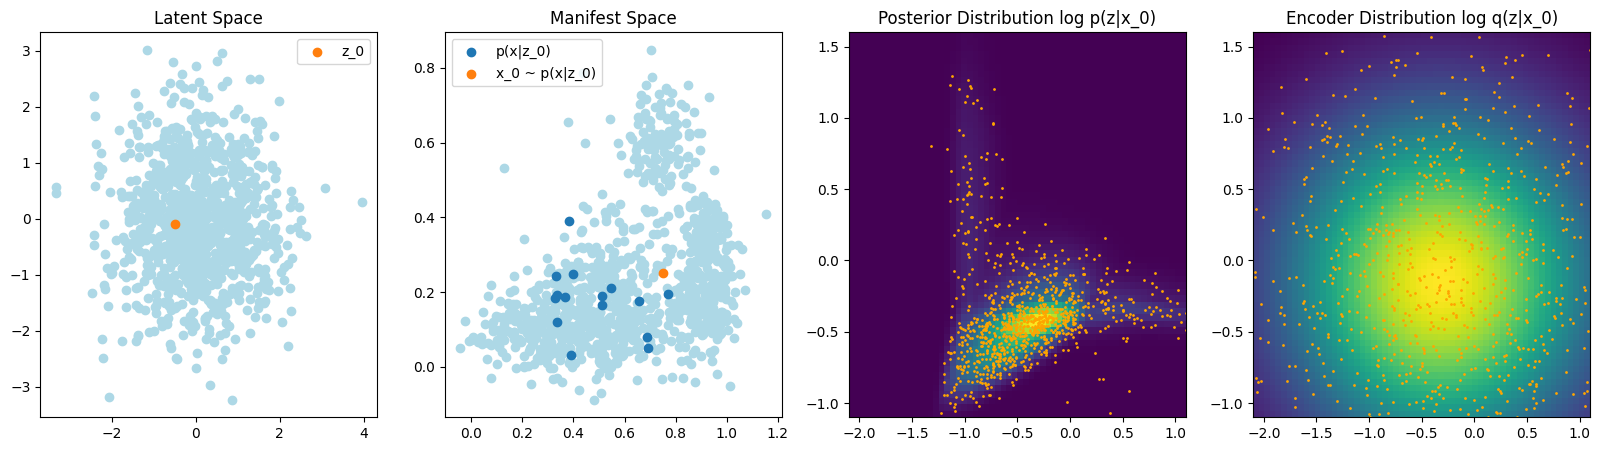

In [9]:
def one_point_analysis(show_samples=True):
    n_samples = 1000
    n_samples2 = 1000
    n_dec = 15
    latent_xlim = (-2.1, 1.1)
    latent_ylim = (-1.1, 1.6)
    dpi = 60
    # arbitrary point in latent space
    z_0 = torch.tensor([-0.5, -0.1], device=device)
    # sample from the decoder distribution
    decoder_distribution = vae.decoder_distribution(z_0.unsqueeze(0))
    xs = decoder_distribution.sample((n_dec,)).squeeze()
    x_0 = xs[:1]
    x_0 = torch.tensor([0.75, 0.25], device=device)

    fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
    ax = axs[0]
    ax.set_title('Latent Space')
    ax.scatter(*pl(vae.prior.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(z_0), color='tab:orange', label='z_0')

    ax = axs[1]
    ax.set_title('Manifest Space')
    ax.scatter(*pl(vae.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(xs), label='p(x|z_0)')
    ax.scatter(*pl(x_0), label='x_0 ~ p(x|z_0)')
    # ax.scatter(*pl(vae.reconstruct(x_0.unsqueeze(0))), label='Reconstruction of x_0')

    ax = axs[3]
    ax.set_title('Encoder Distribution log q(z|x_0)')
    img3 = plot_2d_torch_function(ax, vae.encoder_distribution(x_0).prob, latent_xlim, latent_ylim, dpi, device=device)
    if show_samples:
        encoder_samples = vae.encoder_distribution(x_0).sample((n_samples2,))
        ax.scatter(*pl(encoder_samples), s=1, c='orange')
        ax.set_xlim(latent_xlim)
        ax.set_ylim(latent_ylim)
    
    ax = axs[2]
    ax.set_title('Posterior Distribution log p(z|x_0)')
    img2 = plot_2d_torch_function(ax, vae.posterior(x_0).prob, latent_xlim, latent_ylim, dpi, device=device)
    if show_samples:
        n_langevin_steps = 1000
        kernel = LangevinKernel(vae.posterior(x_0), 0.025, True)
        posterior_samples = encoder_samples
        acc_rates = []
        for i in range(n_langevin_steps):
            posterior_samples, acc_rate = kernel.step(posterior_samples)
            acc_rates.append(acc_rate.mean().item())
        print(f'MALA Posterior Sampling A/R: {statistics.mean(acc_rates):0.3f}')
        ax.scatter(*pl(posterior_samples), s=1, c='orange')
        ax.set_xlim(latent_xlim)
        ax.set_ylim(latent_ylim)

    # unify_clim(img2, img3)
    
    for ax in axs[:2]:
        ax.legend()

one_point_analysis()

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]


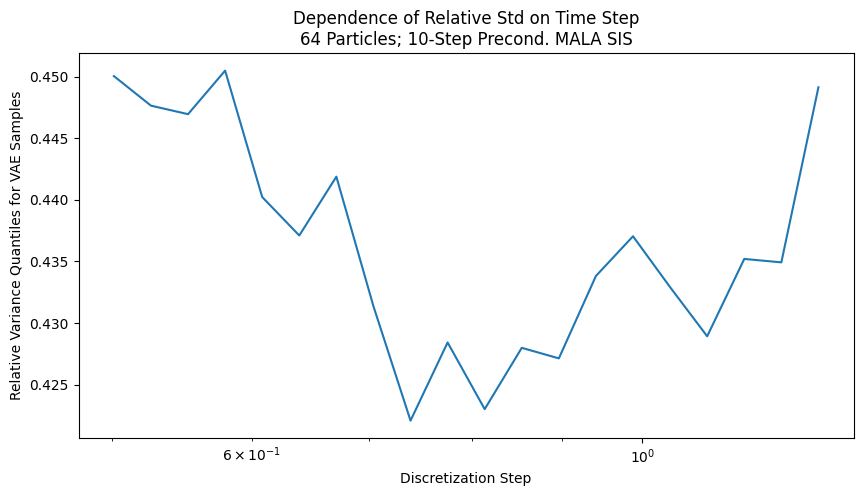

In [39]:
def vae_likelihood_estimation_variance_by_time_step():
    n_samples = 2048
    time_step_options = np.logspace(-0.3, 0.1, 20)  # Langevin time step options
    estimator = SISLikelihoodEstimator(
        model=vae,
        L=64,
        time_step=None,
        precondition=True
    )

    vae_samples = vae.sample((n_samples,))

    test_logs = defaultdict(list)
    for time_step in tqdm(time_step_options):
        estimator.time_step = time_step
        log_likelihoods, variances = estimator(vae_samples, return_variance=True)
        rel_variance = variances.sqrt() / log_likelihoods.exp()
        test_logs['median_rv'].append(rel_variance.median().item())
        # test_logs['q1_rv'].append(rel_variance.quantile(q=0.55))
        # test_logs['q2_rv'].append(rel_variance.quantile(q=0.45))

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f'Dependence of Relative Std on Time Step\n{estimator.L} Particles; {estimator.friendly_name}')
    ax.set_xlabel('Discretization Step')
    ax.set_xscale('log')
    ax.set_ylabel('Relative Variance Quantiles for VAE Samples')
    ax.plot(time_step_options, test_logs['median_rv'], color='tab:blue')
    # ax.plot(time_step_options, test_logs['q1_rv'], color='tab:blue', linestyle='--')
    # ax.plot(time_step_options, test_logs['q2_rv'], color='tab:blue', linestyle='--')

vae_likelihood_estimation_variance_by_time_step()

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


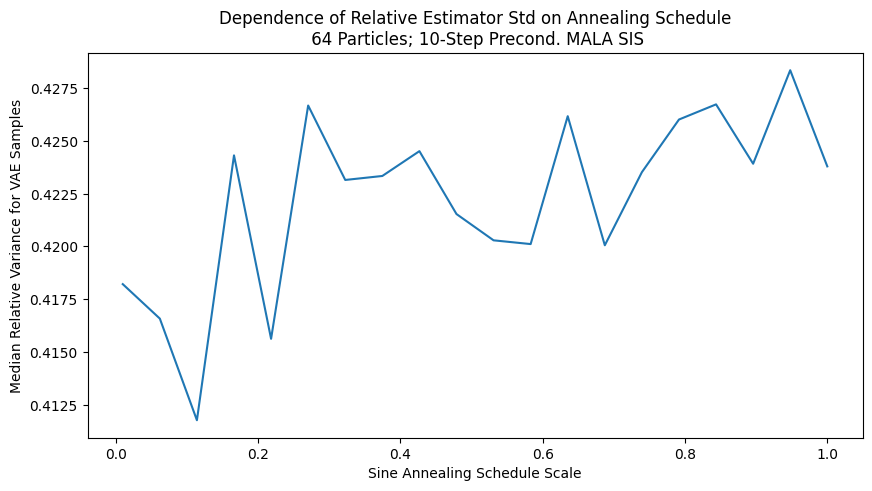

In [46]:
def vae_likelihood_variance_by_schedule():
    n_samples = 2048
    annealing_scale_options = np.linspace(0.01, 1., 20)
    estimator = SISLikelihoodEstimator(
        model=vae,
        L=64,
        time_step=0.8,
        precondition=True,
        annealing_schedule='sine'
    )
    schedule_name = estimator.annealing_schedule.capitalize()

    vae_samples = vae.sample((n_samples,))

    test_logs = defaultdict(list)
    for annealing_scale in tqdm(annealing_scale_options):
        estimator.annealing_scale = annealing_scale
        log_likelihoods, variances = estimator(vae_samples, return_variance=True)
        test_logs['rel_variance'].append((variances.sqrt() / log_likelihoods.exp()).median().item())

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f'Dependence of Relative Estimator Std on Annealing Schedule\n {estimator.L} Particles; {estimator.friendly_name}')
    ax.set_xlabel(f'{schedule_name} Annealing Schedule Scale')
    # ax.set_xscale('log')
    ax.set_ylabel('Median Relative Variance for VAE Samples')
    ax.plot(annealing_scale_options, test_logs['rel_variance'])

vae_likelihood_variance_by_schedule()

In [7]:
torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [02:37<00:00,  6.31s/it]


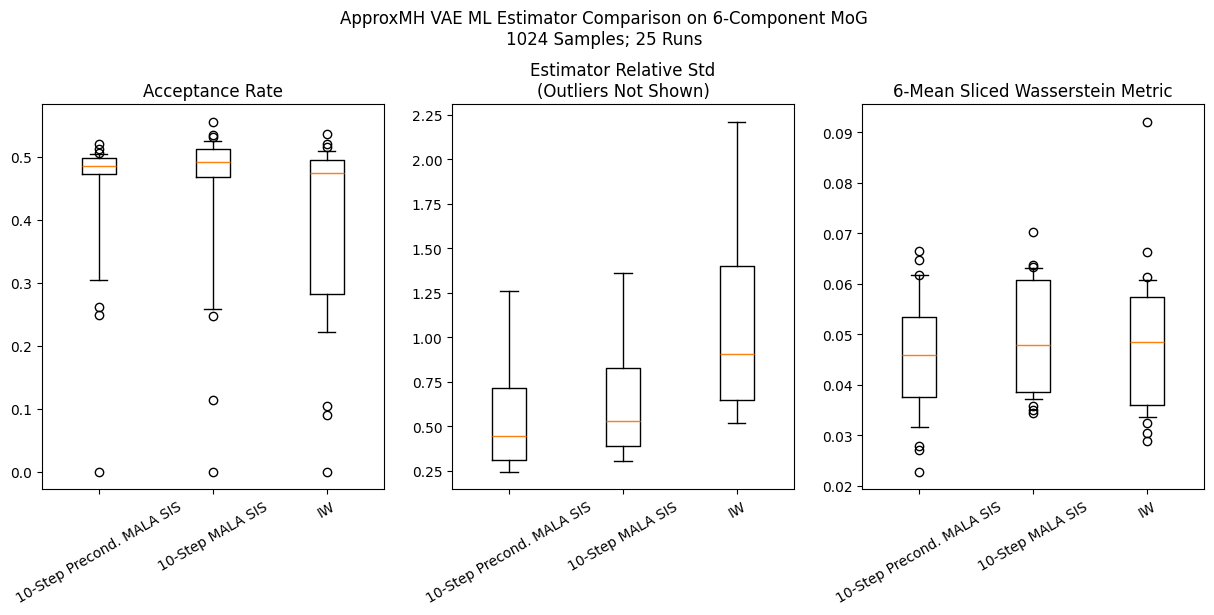

In [52]:
# messed up code, needs fixing
def compare_estimates():
    L = 128
    iw_estimator = IWLikelihoodEstimator(
        model=vae,
        L=L
    )
    sis_estimator = SISLikelihoodEstimator(
        model=vae,
        L=L,
        n_steps=10,
        time_step=0.06,
        precondition=False
    )
    precond_sis_estimator = SISLikelihoodEstimator(
        model=vae,
        L=L,
        n_steps=10,
        time_step=0.8,
        precondition=True
    )
    estimators = [precond_sis_estimator, sis_estimator, iw_estimator]
    estimator_names = [e.friendly_name for e in estimators]
    n_ests = len(estimators)
    # Comparison parameters
    n_runs = 25
    n_samples = 1024
    sample_metric = SlicedDistributionMetric(WassersteinMetric1d(), 3 * target.dim)
    # Plotting parameters
    whiskers = (10, 90)  # Box plot whisker percentiles

    target_samples = target.sample((n_samples,))
    test_logs = defaultdict(lambda: [list() for _ in range(n_ests)]) 
    
    for run_i in tqdm(range(n_runs)):
        vae_samples = vae.sample((n_samples,))
        for i, estimator in enumerate(estimators):
            log_likelihoods, variances = estimator(vae_samples, return_variance=True)
            test_logs['likelihoods'][i].append(log_likelihoods.exp().detach())
            test_logs['variances'][i].append(variances.detach())
            # shuffled_vae_samples = vae_samples[torch.randperm(n_samples)]
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, vae_samples, estimator)
            test_logs['acc_rate'][i].append(mh_acc_rate)
            test_logs['sample_metric'][i].append(sample_metric(target_samples, vae_samples).item())

    for name in ('variances', 'likelihoods'):
        test_logs[name] = torch.stack(tuple(map(torch.cat, test_logs[name])))

    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    ax = axs[0]
    ax.set_title('Acceptance Rate')
    ax.boxplot(
        test_logs['acc_rate'], 
        tick_labels=estimator_names,
        whis=whiskers
    )

    ax = axs[1]
    ax.set_title('Estimator Relative Std\n(Outliers Not Shown)')
    ax.boxplot(
        list(to_numpy(test_logs['variances'].sqrt() / test_logs['likelihoods'])), 
        tick_labels=estimator_names,
        whis=whiskers,
        showfliers=False
    )
    # ax.set_ylim(0., 10.)

    ax = axs[2]
    ax.set_title(sample_metric.name())
    ax.boxplot(
        test_logs['sample_metric'], 
        tick_labels=estimator_names,
        whis=whiskers,
        showfliers=True
    )

    for ax in axs:
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.suptitle(f'ApproxMH VAE ML Estimator Comparison on {target.friendly_name}\n{n_samples} Samples; {n_runs} Runs', y=1.07)

compare_estimates()

Average A/R: 0.652


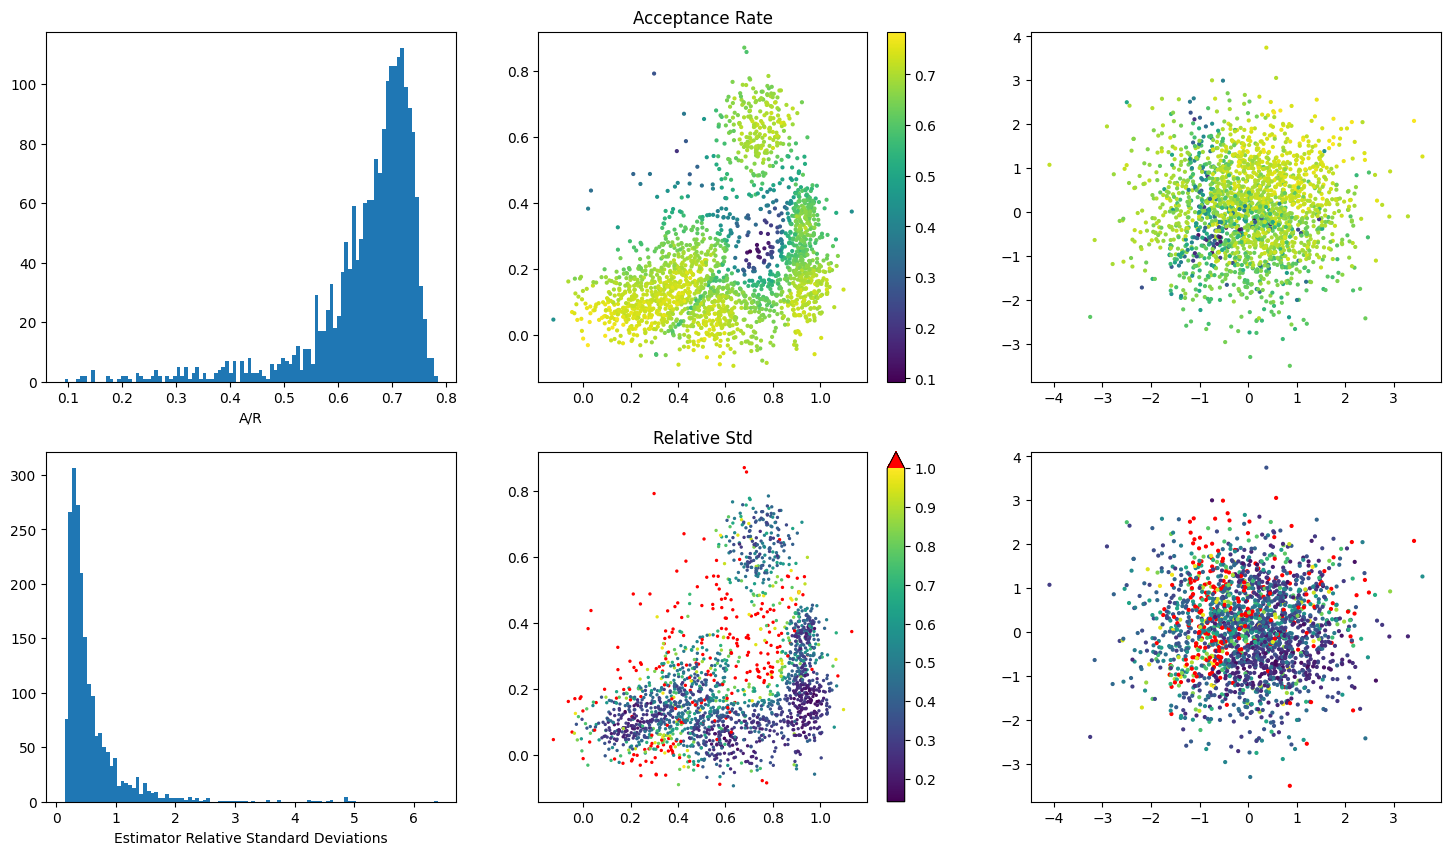

In [58]:
def analysis_by_vae_sample():
    # Estimator
    estimator = SISLikelihoodEstimator(
        model=vae,
        L=64,
        n_steps=10,
        time_step=0.8,
        precondition=True
    )
    n_samples = 2_000

    vae_samples_latent = vae.prior.sample((n_samples,))
    vae_samples = vae.decode(vae_samples_latent)
    # vae_samples = target.sample((n_samples,))
    info_dict = defaultdict(list)
    log_likelihoods, variances = estimator(vae_samples, return_variance=True, info_dict=info_dict)
    acc_rates = info_dict['acceptance_rate']
    rel_stds = variances.sqrt() / log_likelihoods.exp()
    reconstruction_log_probs = []
    for i in range(50):
        reconstruction_log_probs.append(vae.decoder_distribution(vae.encode(vae_samples)).log_prob(vae_samples).detach())
    reconstruction_log_prob = torch.stack(reconstruction_log_probs).logsumexp(dim=0)

    fig, axs = plt.subplots(figsize=(18, 10), ncols=3, nrows=2)
    axs = axs.flatten()

    ax = axs[0]
    ax.hist(to_numpy(acc_rates), bins=100)
    ax.set_xlabel('A/R')
    
    ax = axs[1]
    # ax.set_yscale('log')
    ax.set_title('Acceptance Rate')
    sc = ax.scatter(*pl(vae_samples), c=to_numpy(acc_rates), s=4)
    plt.colorbar(sc)

    ax = axs[2]
    ax.scatter(*pl(vae_samples_latent), c=to_numpy(acc_rates), s=4)

    ax = axs[3]
    ax.hist(to_numpy(rel_stds), bins=100)
    ax.set_xlabel('Estimator Relative Standard Deviations')
    
    ax = axs[4]
    # ax.set_yscale('log')
    ax.set_title('Relative Std')
    cmap = plt.get_cmap('viridis')
    cmap.set_over('red')
    sc = ax.scatter(*pl(vae_samples), c=to_numpy(rel_stds), cmap=cmap, vmax=1, s=2)
    plt.colorbar(sc, extend='max')

    ax = axs[5]
    ax.scatter(*pl(vae_samples_latent), c=to_numpy(rel_stds), cmap=cmap, vmax=1, s=4)

    print(f'Average A/R: {acc_rates.mean().item():0.3f}')
    

analysis_by_vae_sample()

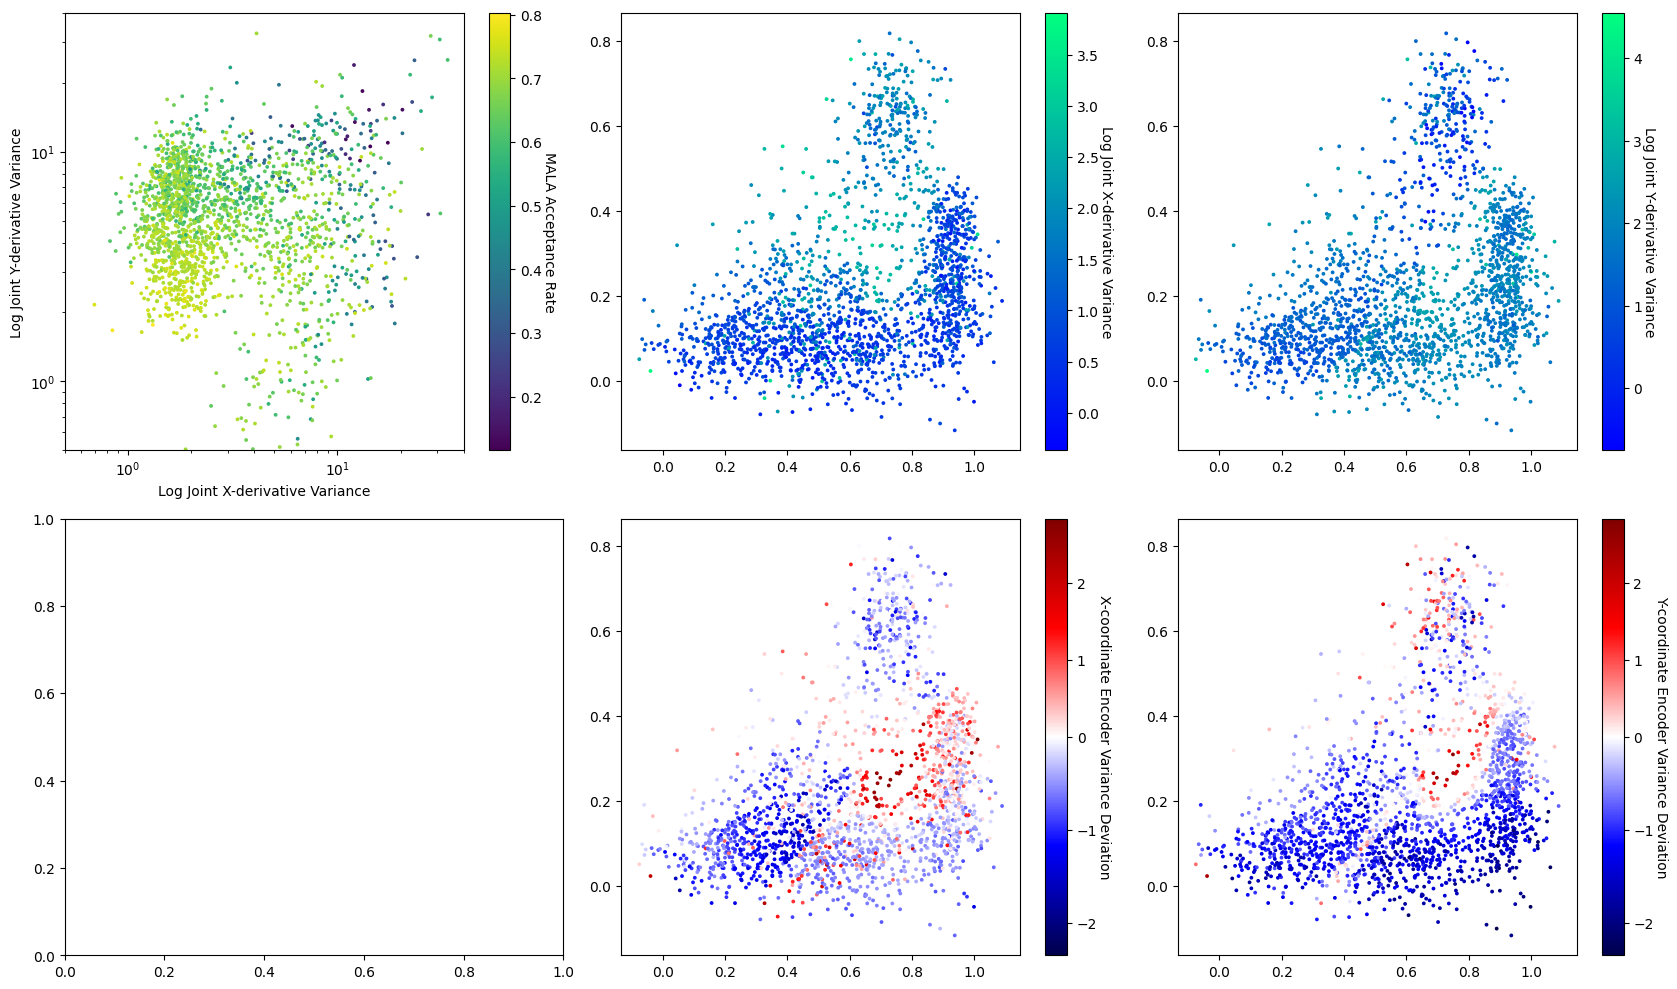

In [64]:
def posterior_condition_number():
    n_samples = 2000
    estimator = SISLikelihoodEstimator(
        model=vae,
        L=64,
        n_steps=10,
        time_step=0.8,
        precondition=True
    )

    vae_samples = vae.sample((n_samples,))
    _, log_encoder_variance = vae.encoding_parameters(vae_samples)
    encoder_samples = vae.encoder_distribution(vae_samples).sample((estimator.L,)).requires_grad_(True)
    unnormalized_posteriors = vae.posterior(vae_samples)
    posterior_probs = unnormalized_posteriors.log_prob(encoder_samples)
    posterior_grads = torch.autograd.grad(posterior_probs.sum(), encoder_samples)[0]
    scales = posterior_grads.std(dim=0)

    info_dict = defaultdict(list)
    log_likelihoods, variances = estimator(vae_samples, return_variance=True, info_dict=info_dict)
    acc_rates = info_dict['acceptance_rate']
    relative_variances = variances / torch.exp(2 * log_likelihoods)

    fig, axs = plt.subplots(figsize=(17, 10), ncols=3, nrows=2)
    axs = axs.flatten()

    ax = axs[0]
    ax.set_xlabel('Log Joint X-derivative Variance')
    ax.set_ylabel('Log Joint Y-derivative Variance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    xylim = (0.5, 40)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    sc = ax.scatter(*pl(scales), s=3, c=to_numpy(acc_rates))
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('MALA Acceptance Rate', rotation=-90, labelpad=10.)

    ax = axs[1]
    sc1 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 0].log()), cmap='winter')
    cbar = plt.colorbar(sc1)
    cbar.ax.set_ylabel('Log Joint X-derivative Variance', rotation=-90, labelpad=10.)

    ax = axs[2]
    sc2 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 1].log()), cmap='winter')
    cbar = plt.colorbar(sc2)
    cbar.ax.set_ylabel('Log Joint Y-derivative Variance', rotation=-90, labelpad=10.)

    ax = axs[4]
    sc3 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 0].log() + log_encoder_variance[:, 0]), cmap='seismic', norm=mpl.colors.TwoSlopeNorm(0))
    cbar = plt.colorbar(sc3)
    cbar.ax.set_ylabel('X-coordinate Encoder Variance Deviation', rotation=-90, labelpad=10.)

    ax = axs[5]
    sc4 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 1].log() + log_encoder_variance[:, 1]), cmap='seismic', norm=mpl.colors.TwoSlopeNorm(0))
    cbar = plt.colorbar(sc4)
    cbar.ax.set_ylabel('Y-coordinate Encoder Variance Deviation', rotation=-90, labelpad=10.)

    # unify_clim(sc1, sc2)
    unify_clim(sc3, sc4)
    plt.tight_layout()

posterior_condition_number()

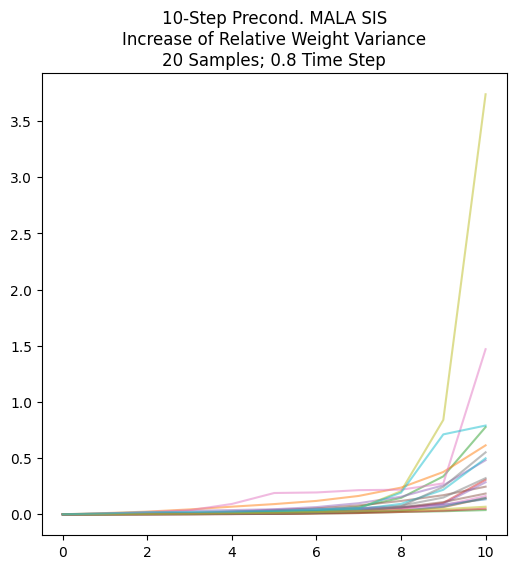

In [69]:
def sis_importance_weight_variance_dynamics():
    estimator = SISLikelihoodEstimator(
        model=vae,
        L=64,
        n_steps=10,
        time_step=0.8,
        precondition=True
    )
    n_samples = 20
    vae_samples = vae.sample((n_samples,))

    # all_weight_variances - [n_samples * (n_steps + 1)] tensor
    all_log_mean_weights, all_weight_variances = estimator(vae_samples, return_variance=True, return_all_steps=True)
    log_likelihoods = all_log_mean_weights[..., -1]
    all_relative_weight_variances = all_weight_variances / torch.exp(2 * log_likelihoods).unsqueeze(-1)
    normalized_variance_trajectories = all_weight_variances / all_weight_variances[:, -1].unsqueeze(-1)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f'{estimator.friendly_name}\nIncrease of Relative Weight Variance\n{n_samples} Samples; {estimator.time_step} Time Step')

    ax.plot(np.arange(estimator.n_steps + 1), to_numpy(all_relative_weight_variances.T), alpha=0.5)
    # ax.set_ylim(0, 1.05)

sis_importance_weight_variance_dynamics()

Local A/R in LG: 0.711
CPU times: user 2min 49s, sys: 106 ms, total: 2min 49s
Wall time: 21.4 s


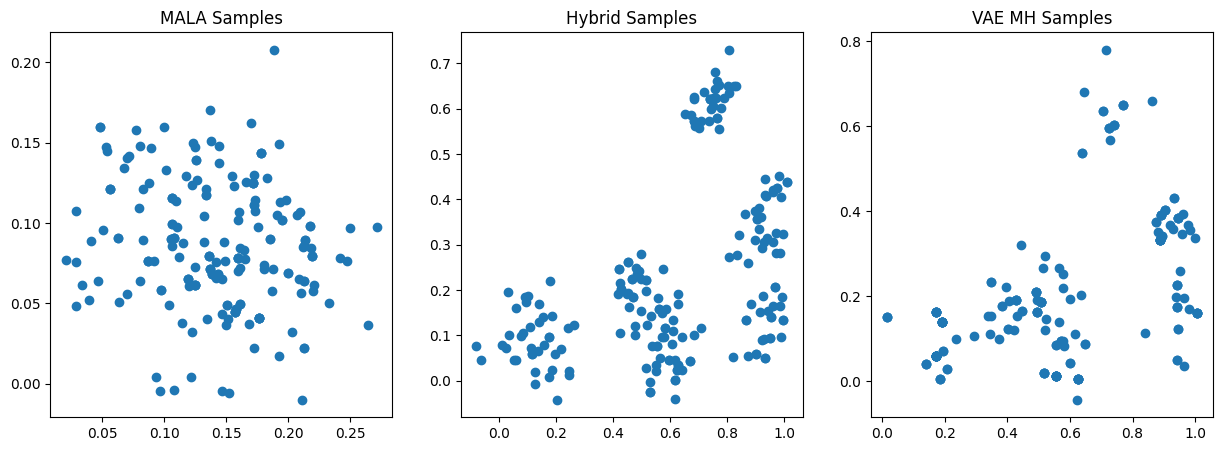

In [21]:
%%time

def test_local_global():
    estimator = SISLikelihoodEstimator(
        model=vae,
        L=64,
        n_steps=10,
        time_step=0.8,
        precondition=True
    )
    n_samples = 200
    n_local_steps=1
    n_isir_particles=64
    local_step_size = 0.002
    lg_sampler = LocalGlobalSampler(
        target=target,
        global_model=vae,
        model_likelihood_estimate=estimator,
        n_local_steps=n_local_steps,
        n_isir_particles=n_isir_particles,
        local_step_size=local_step_size,
        device=device
    )
    local_kernel = LangevinKernel(target, local_step_size, mh_corrected=True)

    vae_samples = vae.sample((n_samples,))
    global_ar, global_samples = metropolis_hastings_filter(target, vae_samples, estimator)

    local_samples = [torch.zeros(target.dim, device=device)]
    for i in range(n_samples):
        local_samples.append(local_kernel.step(local_samples[-1], return_acc_prob=False))
    local_samples = torch.stack(local_samples[1:])

    lg_samples, lg_ar = lg_sampler.sample(n_samples)

    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    ax = axs[0]
    ax.set_title('MALA Samples')
    ax.scatter(*pl(local_samples))

    ax = axs[1]
    ax.set_title('Hybrid Samples')
    ax.scatter(*pl(lg_samples))

    ax = axs[2]
    ax.set_title('VAE MH Samples')
    ax.scatter(*pl(global_samples))

    print(f'Local A/R in LG: {lg_ar.item():0.3f}')

test_local_global()